# Experiment on Retina dataset

In [15]:
import kagglehub
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

path = kagglehub.dataset_download("abdallahwagih/retina-blood-vessel")

print("Path to dataset files:", path)

Path to dataset files: /home/antoine/.cache/kagglehub/datasets/abdallahwagih/retina-blood-vessel/versions/1


In [16]:
def load_retina_data(path):
    
    def load_dir(path,dir_name):
        path_dir = os.path.join(path, dir_name)
        images = []
        masks = []
        
        # List image and mask files and sort them for consistency
        img_files = sorted(os.listdir(os.path.join(path_dir, "image")))
        mask_files = sorted(os.listdir(os.path.join(path_dir, "mask")))
        
        for img_file, mask_file in zip(img_files, mask_files):
            img_path = os.path.join(path_dir, "image", img_file)
            mask_path = os.path.join(path_dir, "mask", mask_file)
            
            # Load and resize the image
            img = Image.open(img_path).convert("RGB")
            mask = Image.open(mask_path).convert("L") 
            
            # Normalize pixel values to [0, 1]
            img = np.array(img) / 255.0
            mask = np.array(mask) / 255.0
            
            # Append to lists
            images.append(img)
            masks.append(mask)
        
        return np.array(images), np.array(masks)
    x_train,y_train = load_dir(path,"train")
    x_test,y_test = load_dir(path,"test")
    return x_train,y_train,x_test,y_test

In [17]:
x_train_img,y_train_img,x_test_img,y_test_img = load_retina_data(os.path.join(path,"Data"))

In [18]:

def balanced_data(x_train_img, y_train_img, x_test_img, y_test_img, nb_channel=3):
    x_train_pixelled= x_train_img.reshape(-1,nb_channel)
    y_train_pixelled =np.array(y_train_img.reshape(-1), dtype=np.int64)
    x_test_pixelled= x_test_img.reshape(-1,nb_channel)
    y_test_pixelled =np.array(y_test_img.reshape(-1), dtype=np.int64)
    def get_balanced_dataset(x,y):
        x_0 = x[y==0]
        x_1 = x[y==1]
        
        nb_to_keep = min(x_0.shape[0], x_1.shape[0])
        
        x_0 = x_0[np.random.permutation(x_0.shape[0])]
        x_1 = x_1[np.random.permutation(x_1.shape[0])]
        x_new = np.concatenate((x_0[:nb_to_keep],x_1[:nb_to_keep]),axis=0)
        y_new = np.concatenate([np.zeros(nb_to_keep, dtype=y.dtype), np.ones(nb_to_keep, dtype=y.dtype)], axis=0, dtype=y.dtype)
        index_shuffle = np.random.permutation(x_new.shape[0])
        
        return x_new[index_shuffle], y_new[index_shuffle]
    
    x_train_balanced, y_train_balanced = get_balanced_dataset(x_train_pixelled,y_train_pixelled)
    print(x_train_pixelled.shape, y_train_pixelled.shape)
    print(x_train_balanced.shape, y_train_balanced.shape)
    print(y_train_balanced.mean())
    return x_train_balanced, y_train_balanced, x_train_pixelled, x_test_pixelled, y_train_pixelled, y_test_pixelled

x_train_balanced, y_train_balanced, x_train_pixelled, x_test_pixelled, y_train_pixelled, y_test_pixelled = balanced_data(x_train_img, y_train_img, x_test_img, y_test_img)

(20971520, 3) (20971520,)
(2244910, 3) (2244910,)
0.5


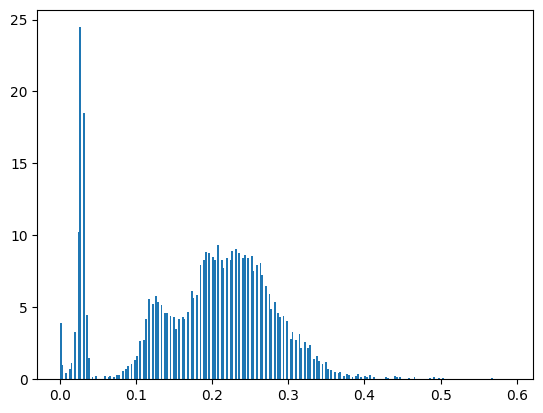

In [19]:
nb_data_train = int(1e4)
nb_data_test = int(1e4)
x_train,x_test = x_train_balanced[:nb_data_train], x_test_pixelled[np.random.permutation(x_test_pixelled.shape[0])[:nb_data_test]]
y_train, y_test = y_train_balanced[:nb_data_train], y_test_pixelled[np.random.permutation(y_test_pixelled.shape[0])[:nb_data_test]]
plt.hist(x_train[:,2], bins=255, density=True)
plt.show()


In [20]:
from GDA import GDA


model = GDA(10)
model.fit(x_train, y_train)


In [21]:
def print_metrics(y_val_pred,y_val):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

    # Assuming y_val_pred contains predictions and y_val contains true labels
    accuracy = accuracy_score(y_val, y_val_pred)
    precision = precision_score(y_val, y_val_pred, average='weighted')
    recall = recall_score(y_val, y_val_pred, average='weighted')
    f1 = f1_score(y_val, y_val_pred, average='weighted')
    conf_matrix = confusion_matrix(y_val, y_val_pred)
    
    print("Accuracy:", accuracy)
    print("Precision (Weighted):", precision)
    print("Recall (Weighted):", recall)
    print("F1-Score (Weighted):", f1)
    print("\nConfusion Matrix:\n", conf_matrix)
    
    # Detailed classification report
    print("\nClassification Report:\n", classification_report(y_val, y_val_pred))
    
y_test_pred = model.predict(x_test)
print_metrics(y_test_pred,y_test)

Accuracy: 0.5604
Precision (Weighted): 0.9037828954691458
Recall (Weighted): 0.5604
F1-Score (Weighted): 0.678013569918076

Confusion Matrix:
 [[5372 4113]
 [ 283  232]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.57      0.71      9485
           1       0.05      0.45      0.10       515

    accuracy                           0.56     10000
   macro avg       0.50      0.51      0.40     10000
weighted avg       0.90      0.56      0.68     10000



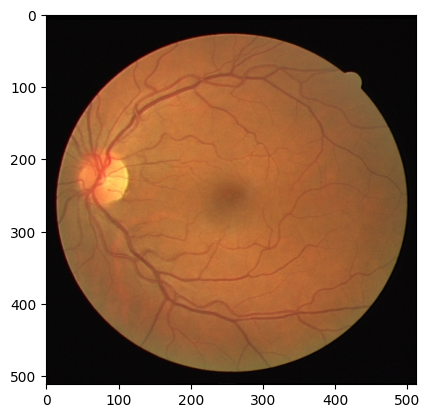

In [22]:
img = x_test_img[0]
y_true = y_test_img[0]
img_p = img.copy().reshape(-1,3)
plt.imshow(img)

In [23]:
pred = model.predict(img_p).reshape(img.shape[:2])

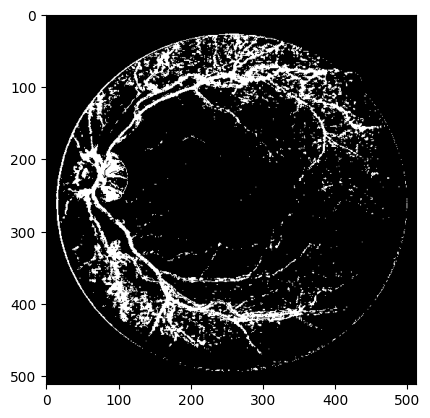

In [24]:
plt.imshow(pred, cmap="gray")

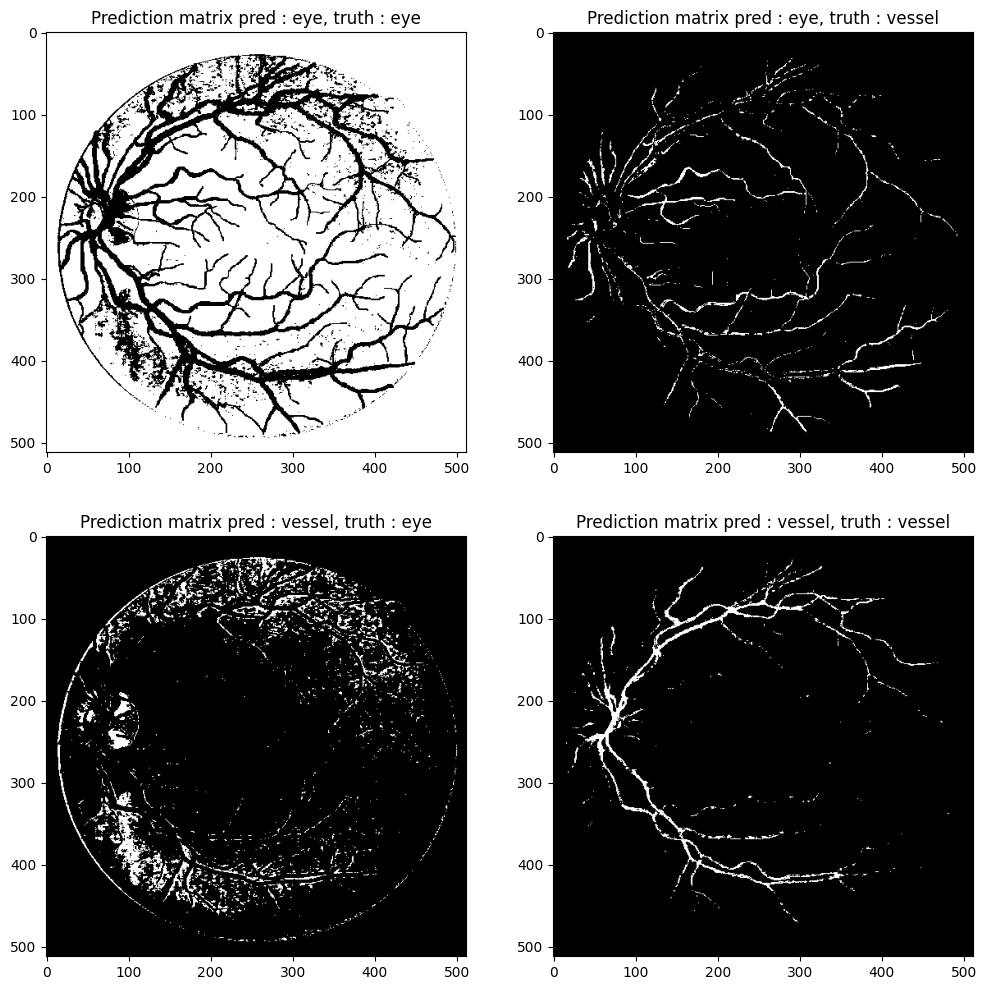

In [25]:
plt.figure(figsize=(12, 12))
for k,(i,j) in enumerate([(0,0),(0,1),(1,0),(1,1)]):
    plt.subplot(2, 2, k+1) 
    plt.imshow(np.array(pred == i, dtype=np.float32)*np.array(y_true == j , dtype=np.float32), cmap="gray")
    plt.title(f"Prediction matrix pred : {'vessel' if i==1 else 'eye'}, truth : {'vessel' if j==1 else 'eye'}") 



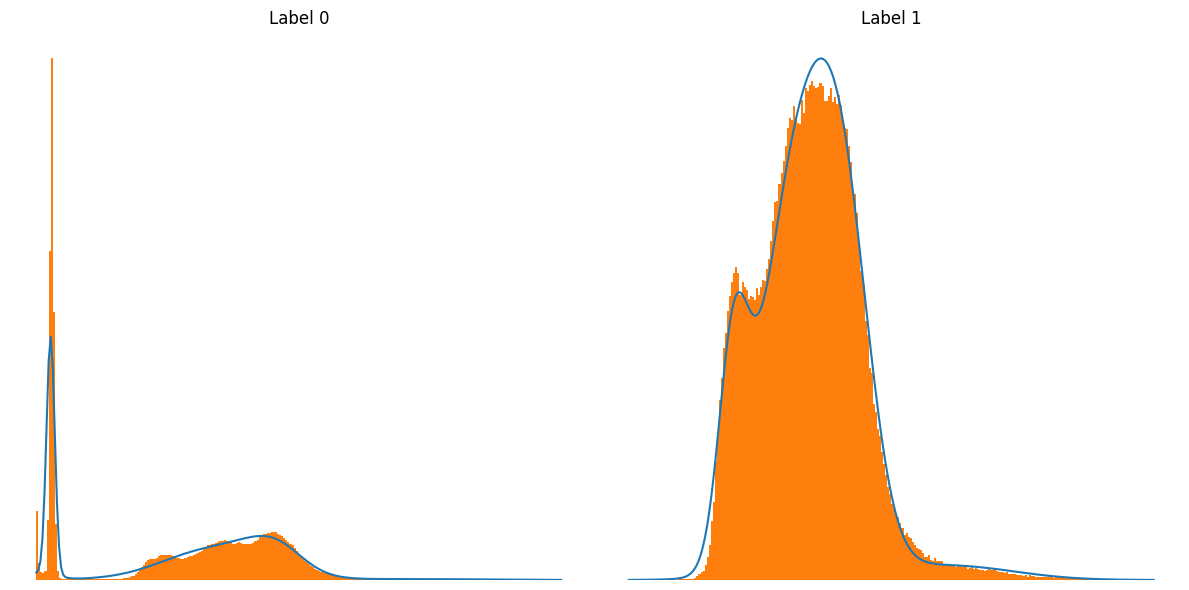

In [26]:
import matplotlib.pyplot as plt
import scipy
def marginal_density(gmm_means, gmm_covs, gmm_probs, dim_to_keep, points):
    """
    Compute the marginal density of the GMM
    """
    density_values = np.zeros(len(points))
    
    for mean, cov, prob in zip(gmm_means, gmm_covs, gmm_probs):
        mean_marginal = mean[dim_to_keep]
        cov_marginal = cov[np.ix_(dim_to_keep, dim_to_keep)]
        
        marginal_gaussian = scipy.stats.multivariate_normal(mean=mean_marginal, cov=cov_marginal)
        
        # Compute the density for each component
        density_values += prob * marginal_gaussian.pdf(points)
    
    return density_values
t = np.linspace(0,1,255)

plt.figure(figsize=(12, 6)) 
channel_index = 1
nb_plots = len(model.gmms)
for i,(y_val,gmm) in enumerate(model.gmms.items()):
    plt.subplot(1, nb_plots, i+1) 
    density = marginal_density(gmm.means_, gmm.covariances_, gmm.weights_, [channel_index], t)
    plt.plot(t,density)
    plt.hist(x_train_balanced[y_train_balanced==y_val,channel_index], bins=255, density=True) 
    plt.title(f"Label {y_val}") 
    plt.axis("off") 


plt.tight_layout()
plt.show()


## Filters

In [27]:
from scipy.ndimage import gaussian_filter

def apply_gaussian_blur(image, sigma=2):
    return gaussian_filter(image, sigma=sigma)

from scipy.ndimage import laplace

def apply_sharpening(image, alpha=1.0):
    laplacian = laplace(image)
    return image + alpha * laplacian


from scipy.ndimage import gaussian_laplace

def apply_log_filter(image, sigma=2):
    return gaussian_laplace(image, sigma=sigma)

from scipy.ndimage import median_filter

def apply_median_filter(image, size=3):
    return median_filter(image, size=size)

def transform(images, fun):
    return np.concatenate([images,np.vectorize(fun)(images)], axis=-1)
def generate_feature_stack(image):
    features = [
        image,  # Original
        apply_gaussian_blur(image, sigma=2),
        apply_sharpening(image),
        apply_log_filter(image, sigma=2),
        apply_median_filter(image, size=3)
    ]
    return np.stack(features, axis=-1)

In [28]:
function_to_test = apply_median_filter
nb_channel = 6

x_train_img,x_test_img = transform(x_train_img[:10], function_to_test), transform(x_test_img[:10], function_to_test)
y_train_img, y_test_img = y_train_img[:10], y_test_img[:10]

KeyboardInterrupt: 

In [14]:
print(x_train_img.shape, y_train_img.shape, x_test_img.shape, y_test_img.shape)

(10, 512, 512, 6) (10, 512, 512) (10, 512, 512, 6) (10, 512, 512)


In [15]:
x_train_balanced, y_train_balanced, x_train_pixelled, x_test_pixelled, y_train_pixelled, y_test_pixelled = balanced_data(x_train_img, y_train_img, x_test_img, y_test_img, nb_channel=nb_channel)



(2621440, 6) (2621440,)
(317436, 6) (317436,)
0.5


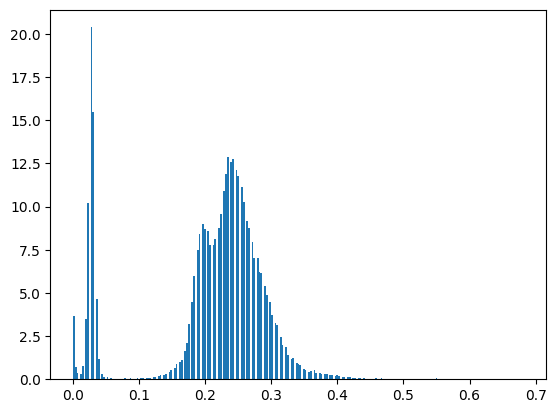

In [16]:
nb_data_train = int(1e5)
nb_data_test = int(1e4)
x_train,x_test = x_train_balanced[:nb_data_train], x_test_pixelled[np.random.permutation(x_test_pixelled.shape[0])[:nb_data_test]]
y_train, y_test = y_train_balanced[:nb_data_train], y_test_pixelled[np.random.permutation(y_test_pixelled.shape[0])[:nb_data_test]]
plt.hist(x_train[:,2], bins=255, density=True)
plt.show()


In [17]:
from GDA import GDA

model = GDA(3)
model.fit(x_train, y_train)


In [18]:
y_test_pred = model.predict(x_test)
print_metrics(y_test_pred,y_test)

Accuracy: 0.6073
Precision (Weighted): 0.9022759100099856
Recall (Weighted): 0.6073
F1-Score (Weighted): 0.7158819768747264

Confusion Matrix:
 [[5882 3606]
 [ 321  191]]

Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.62      0.75      9488
           1       0.05      0.37      0.09       512

    accuracy                           0.61     10000
   macro avg       0.50      0.50      0.42     10000
weighted avg       0.90      0.61      0.72     10000



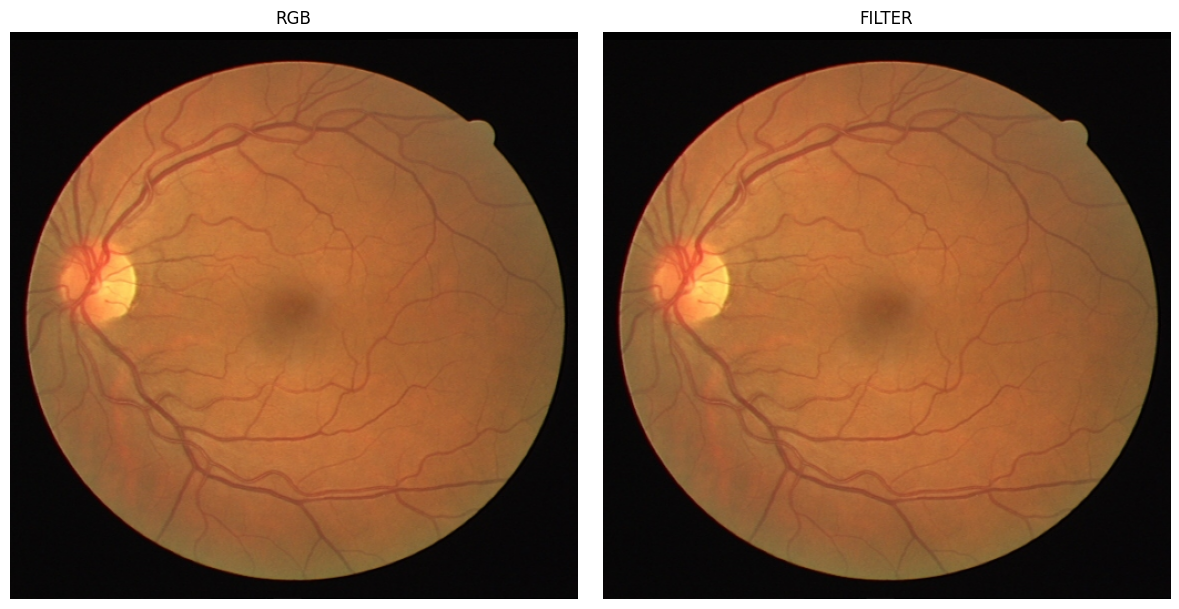

In [19]:
img = x_test_img[0]
img_p = img.copy().reshape(-1,nb_channel)

plt.figure(figsize=(12, 6)) 

plt.subplot(1, 2, 1) 
plt.imshow(img[:, :, :3])  
plt.title("RGB") 
plt.axis("off") 

plt.subplot(1, 2, 2)  
plt.imshow(img[:, :, 3:]) 
plt.title("FILTER")  
plt.axis("off") 

plt.tight_layout()
plt.show()



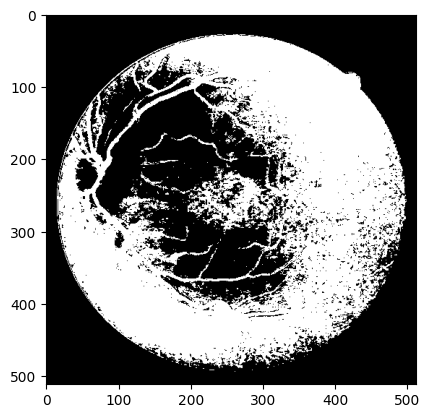

In [20]:
pred = model.predict(img_p).reshape(img.shape[:2])
plt.imshow(pred, cmap="gray")